In [1]:
import numpy as np
from obspy import read
from obspy.io.xseed import Parser
from scipy import signal
import obspy
import matplotlib.pyplot as plt
from IPython.display import Image
from func import def_master

## Loading Data and decimate it to 25Hz by factor 2

In [2]:
### Loading in Data for 3 days to test frequency and amplitude development over several days

station = 'KNR01'
component = 'BH1'
year = 2016
day = 321
day1 = day + 1
day2 = day + 2

day = str(day)
day1 = str(day1)
day2 = str(day2)
year = str(year)


component = 'BHZ'


#st = read('../../TEST_DATA/DATA/KNR01/BHZ.D/1B.KNR01..BHZ.D.2016.337')
st_BHZ = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + component + '.D/1B.' + station + '..' + component + '.D.' + year + '.' + day)
#parser01 = Parser('../../TEST_DATA/Resp/RESP.1B.KNR01..BHZ')
parser01_BHZ = Parser('/data/cen/u254/Essing/AWI/CAL/RESP.1B.' + station + '..' + component)
st_BHZ = st_BHZ.decimate(factor=2)
st_BHZ_simu = st_BHZ.copy()
st_BHZ_simu.simulate(seedresp={'filename': parser01_BHZ, 'units': "ACC"})
st_BHZ_simu_filt = st_BHZ_simu.copy()
st_BHZ_simu_filt = st_BHZ_simu_filt.filter('bandpass',freqmin=.1, freqmax=10)


#st = read('../../TEST_DATA/DATA/KNR01/BHZ.D/1B.KNR01..BHZ.D.2016.337')
st_BHZ_1 = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + component + '.D/1B.' + station + '..' + component + '.D.' + year + '.' + day1)
#parser01 = Parser('../../TEST_DATA/Resp/RESP.1B.KNR01..BHZ')
#parser01_BHZ = Parser('/data/cen/u254/Essing/AWI/CAL/RESP.1B.' + station + '..' + component)
st_BHZ_1 = st_BHZ_1.decimate(factor=2)
st_BHZ_simu_1 = st_BHZ_1.copy()
st_BHZ_simu_1.simulate(seedresp={'filename': parser01_BHZ, 'units': "ACC"})
st_BHZ_simu_filt_1 = st_BHZ_simu_1.copy()
st_BHZ_simu_filt_1 = st_BHZ_simu_filt_1.filter('bandpass',freqmin=.1, freqmax=10)


#st = read('../../TEST_DATA/DATA/KNR01/BHZ.D/1B.KNR01..BHZ.D.2016.337')
st_BHZ_2 = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + component + '.D/1B.' + station + '..' + component + '.D.' + year + '.' + day2)
#parser01 = Parser('../../TEST_DATA/Resp/RESP.1B.KNR01..BHZ')
#parser01_BHZ = Parser('/data/cen/u254/Essing/AWI/CAL/RESP.1B.' + station + '..' + component)
st_BHZ_2 = st_BHZ_2.decimate(factor=2)
st_BHZ_simu_2 = st_BHZ_2.copy()
st_BHZ_simu_2.simulate(seedresp={'filename': parser01_BHZ, 'units': "ACC"})
st_BHZ_simu_filt_2 = st_BHZ_simu_2.copy()
st_BHZ_simu_filt_2 = st_BHZ_simu_filt_2.filter('bandpass',freqmin=.1, freqmax=10)


fs = int(st_BHZ_simu_filt[0].stats.sampling_rate)
date = st_BHZ_simu_filt[0].stats.endtime.ctime()[4:]

/home/zmaw/u300967/.conda/envs/vgseis_2018/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


In [3]:
fs = int(st_BHZ[0].stats.sampling_rate)
first_date = st_BHZ[0].stats.endtime.ctime()[4:]

In [ ]:
## Depends on workstation 
## day 337 in 2016 is  December 2, 2016 (Fri)

#st = read('../../TEST_DATA/DATA/KNR01/BHZ.D/1B.KNR01..BHZ.D.2016.337')
st_BH1 = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + component + '.D/1B.' + station + '..' + component + '.D.' + year + '.' + day)
#parser01 = Parser('../../TEST_DATA/Resp/RESP.1B.KNR01..BHZ')
parser01_BH1 = Parser('/data/cen/u254/Essing/AWI/CAL/RESP.1B.' + station + '..' + component)
st_BH1 = st_BH1.decimate(factor=2)
st_BH1_simu = st_BH1.copy()
st_BH1_simu.simulate(seedresp={'filename': parser01_BH1, 'units': "ACC"})
st_BH1_simu_filt = st_BH1_simu.copy()
st_BH1_simu_filt = st_BH1_simu_filt.filter('bandpass',freqmin=.1, freqmax=10)



component = 'BH2'


#st = read('../../TEST_DATA/DATA/KNR01/BHZ.D/1B.KNR01..BHZ.D.2016.337')
st_BH2 = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + component + '.D/1B.' + station + '..' + component + '.D.' + year + '.' + day)
#parser01 = Parser('../../TEST_DATA/Resp/RESP.1B.KNR01..BHZ')
parser01_BH2 = Parser('/data/cen/u254/Essing/AWI/CAL/RESP.1B.' + station + '..' + component)
st_BH2 = st_BH2.decimate(factor=2)
st_BH2_simu = st_BH2.copy()
st_BH2_simu.simulate(seedresp={'filename': parser01_BH2, 'units': "ACC"})
st_BH2_simu_filt = st_BH2_simu.copy()
st_BH2_simu_filt = st_BH2_simu_filt.filter('bandpass',freqmin=.1, freqmax=10)

In [ ]:
st_BHZ_simu_filt.plot()
st_BH1_simu_filt.plot()
st_BH2_simu_filt.plot()

In [ ]:
figname = str(st[0].stats.station) + st[0].stats.channel #+ st[0].stats.starttime)

print(((str(st[0].stats.station), st[0].stats.channel,st[0].stats.starttime)))

# Filtercorner testing

In [ ]:
st_filt = st.copy()
st_filt = st_filt.filter('bandpass',freqmin=1, freqmax=8)
st_array = np.asarray(st[0].data)
st_filt_array = np.asarray(st_filt[0].data)

fs = int(st_filt[0].stats.sampling_rate)

t_start = fs*20000
t1_start = t_start+fs*8000
st_nofilt_10_min = st_array[t_start:t_start+10*fs*60]
st_filt_10_min = st_filt_array[t_start:t_start+10*fs*60]
#test1_10_min = st_array[t1_start:t1_start+10*fs*60]

In [ ]:
f, Pxx = signal.periodogram(st_nofilt_10_min, fs=fs)
f1,Pxx1 = signal.periodogram(st_filt_10_min, fs=fs)

In [ ]:
#plt.semilogy(f, Pxx)
plt.subplot(121)
plt.plot(f, Pxx,label='nofilt')
#plt.xlim(0,5)
#plt.ylim(1e-4,1e6)
plt.grid()

plt.subplot(122)
plt.plot(f1, Pxx1,label='filt')
#plt.xlim(0,1)
#plt.ylim(1e-4,1e6)
plt.grid()

plt.show()

# Remove response

In [ ]:
parser01 = Parser('../TEST_DATA/Resp/RESP.1B.KNR01..BHZ')
st_simu = st.copy()
st_simu.simulate(seedresp={'filename': parser01, 'units': "ACC"})

In [ ]:
st_simu_filt = st_simu.copy()
st_simu_array = np.array(st_simu[0].data)

st_simu_filt = st_simu_filt.filter('highpass',freq=1)
st_simu_filt_array = np.array(st_simu_filt[0].data)

In [ ]:
plt.plot(st_simu_filt_array)
#plt.xlim(318800,319500)
plt.show()

In [ ]:
t_start = fs*20000
t1_start = t_start+fs*30000

st_simu_nofilt_10_min = st_simu_array[t_start:t_start+10*fs*60]
st_simu_filt_10_min = st_simu_filt_array[t_start:t_start+10*fs*60]

In [ ]:
f2, Pxx2 = signal.periodogram(st_simu_nofilt_10_min, fs=fs)
f3, Pxx3 = signal.periodogram(st_simu_filt_10_min, fs=fs)

In [ ]:
plt.figure(figsize=(11,11))
#plt.semilogy(f, Pxx)
plt.subplot(221)
plt.plot(f, Pxx,label='nofilt')
#plt.xlim(0,5)
#plt.ylim(1e-4,1e6)
plt.legend()
plt.grid()

plt.subplot(222)
plt.plot(f1, Pxx1,label='filt')
#plt.xlim(0,1)
#plt.ylim(1e-4,1e6)
plt.legend()
plt.grid()

#plt.semilogy(f, Pxx)
plt.subplot(223)
plt.plot(f2, Pxx2, label='st_simu_nofilt')
#plt.xlim(0,1)
#plt.ylim(1e-4,1e6)
plt.legend()
plt.grid()

plt.subplot(224)
plt.plot(f3, Pxx3, label='st_simu_filt')
#plt.xlim(0,1)
#plt.ylim(1e-4,1e6)
plt.legend()
plt.grid()

plt.show()

# Signal vs. no signal

In [ ]:
st_simu.plot()

In [ ]:
#t_signal_start = 20000*fs
#t_nosignal_start = 28000*fs
#win_len = 4*60*fs

st_simu_array = np.array(st_simu_filt[0].data)

In [ ]:
st_simu_array1 = np.append(st_simu_array, 0)

In [ ]:
st_simu_signal_1_min = st_simu_array[t_signal_start:t_signal_start+win_len]
f_sig, Pxx_sig = signal.periodogram(st_simu_signal_1_min, fs=fs)

In [ ]:
Image('KNR01.BHZ_2016-12-02T00:00:00.000000Z.png')

In [ ]:
plt.plot(f_sig, Pxx_sig)
plt.plot(f_sig[np.argmax(Pxx_sig)], np.max(Pxx_sig), '.')
#plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
plt.show()

In [ ]:
def search_maxima_in_periodogram(maxima, data, fs=fs, wlen):
    
    '''Function to cut daily data into several windows and searche for maxima in each window
    Input:
    
    maxima    float        number of maxima to search for
    signal    array        array with data
    fs        float        value of sampling rate
    wlen      int          value of window length in seconds
    
    '''

    
    
    
    
    f_sig, Pxx_sig = signal.periodogram(data, fs=fs)
    index_max = np.zeros(maxima)
    value_max_f = np.zeros(maxima)
    value_max = np.zeros(maxima)
    Pxx_sig1 = Pxx_sig.copy()
    
    #wlen = wlen * fs
    #st_simu_signal_1_min = st_simu_array[t_signal_start:t_signal_start+win_len]
    #for wlen in data:
        #data_cut = st_simu_array[t_signal_start:t_signal_start+win_len]
        #print(data_cut)
    for i in range(maxima):

        # first maxima


        index_max[i] = np.argmax(Pxx_sig1)
        value_max_f[i] = f_sig[np.argmax(Pxx_sig1)]
        value_max[i] = np.max(Pxx_sig1)

        minval = np.min(Pxx_sig1)
        Pxx_sig1[int(index_max[i]-10):int(index_max[i]+10)] = minval-100
    #fname = '../Plots/PSD/KNR01..BHZ.D.2016.337' + str(t_signal_start) + '-' + str(t_signal_start+ win_len)
    #plt.semilogy(f_sig, Pxx_sig)
    #plt.semilogy(value_max_f, value_max, 'o')
    #plt.plot(value_ond_max_f, value_second_max, 'o')
    #plt.plot(value_third_max_f, value_third_max, 'o')
    #plt.plot(value_fourth_max_f, value_fourth_max, 'o')
    #plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
    #plt.savefig(fname=fname)
    return(value_max_f, value_max)

In [ ]:
maxima = 8
data= st_simu_signal_1_min

value_max_f, value_max = search_maxima_in_periodogram(maxima, data, fs=fs)

In [ ]:
plt.plot(f_sig, Pxx_sig)
plt.plot(value_max_f, value_max, 'o')
plt.ylim(0*1e-10,6*1e-10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
#plt.xlim(1.2,2)
plt.grid()
#plt.plot(value_ond_max_f, value_second_max, 'o')
#plt.plot(value_third_max_f, value_third_max, 'o')
#plt.plot(value_fourth_max_f, value_fourth_max, 'o')
#plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
plt.show()



# next steps...
# 1) while schleife mit abbruchkriterium nach 4-6 Durchlaeufen
# 2) als definition schreiben
# 3) 

# mlab.specgram

In [4]:
from matplotlib import mlab, transforms
plt.rcParams['image.cmap'] = 'Oranges'
import math as M
import matplotlib as mpl
import numpy.ma as ma

In [5]:
def _nearest_pow_2(x):
    """
    copied from obspy specgram
    Find power of two nearest to x
    >>> _nearest_pow_2(3)
    2.0
    >>> _nearest_pow_2(15)
    16.0
    :type x: float
    :param x: Number
    :rtype: Int
    :return: Nearest power of 2 to x
    """
    a = M.pow(2, M.ceil(np.log2(x)))
    b = M.pow(2, M.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b

    

In [6]:
data_BHZ = np.array(st_BHZ_simu_filt[0].data)
data_BHZ -= data_BHZ.mean()
data_BHZ_1 = np.array(st_BHZ_simu_filt_1[0].data)
data_BHZ_1 -= data_BHZ_1.mean()
data_BHZ_2 = np.array(st_BHZ_simu_filt_2[0].data)
data_BHZ_2 -= data_BHZ_2.mean()

In [7]:
per_lap = .1
wlen = float(fs*10)
npts = len(data_BHZ)
nfft = int(_nearest_pow_2(wlen * fs))
nlap = int(nfft * float(per_lap))

In [8]:
def searchmaxima(maxima, distance, data, scale_vector=0):
    
    '''
    To find maxima in data, with option to give vecotr with scaling values for x-Axis
    
    Input:
    maxima    scalar        value of maxima to find
    distance  scalar        value for nearest next maxima to search for
    data      1-D array     numpy array of data 
    freqvec   1-D array     numpy array of data with values to scale x-Axis (optional)
    
    '''

    index_max = np.zeros(maxima)
    value_max_f = np.zeros(maxima)
    value_max = np.zeros(maxima)
    data1 = data.copy()
    
    if type(scale_vector) == int:
    
        for i in range(maxima):
            index_max[i] = np.argmax((data1))
            value_max[i] = np.max((data1))
            #index_max[i] = np.argmax(Pxx_sig1)
            #value_max_f[i] = freqvec[np.argmax(data1)]
            #value_max[i] = np.max(Pxx_sig1)

            minimal_value = np.min(data1)

            data1[int(index_max[i]-distance):int(index_max[i]+distance)] = minimal_value-100
        return(value_max, index_max)
    
    else:
        for i in range(maxima):
            index_max[i] = np.argmax((data1))
            value_max[i] = np.max((data1))
            value_max_f[i] = scale_vector[np.argmax(data1)]
            minimal_value = np.min(data1)
        
            data1[int(index_max[i]-distance):int(index_max[i]+distance)] = minimal_value-100
            
        return(value_max, index_max,value_max_f)

In [29]:
def sorting_out_peaks(input_data, freq_vec, maxima, distance ,threshold, freq_minimal_value):
    '''
    Calls searchmaxima and just hands maxima values which meet with two options:
            - there is a maximum below a certain frequency value (freq_minimal_value)
            - maximum amplitude value is higher then certain ampiltude (threshold) 
    
    
    '''
    
    amp_values = np.zeros((np.shape(input_data)[1]))
    frequency_indices = np.zeros_like(amp_values)
    frequency_values = np.zeros_like(amp_values)
    
    
    max_array = np.zeros_like(input_data)
    for j in range(np.shape(input_data)[1]):
        win_average = np.mean(input_data.T[j])
        #if win_average < all_win_average:
        # not a good solution. deletes as well some instrument signal

        amp_values[j], frequency_indices[j], frequency_values[j] = searchmaxima(maxima=maxima, data=input_data.T[j],distance=distance, scale_vector=freq_vec)

        #print(any(frequency_value<freq_minimal_value))
        if any(frequency_values<freq_minimal_value) == True:
            #print((frequency_value))
            for i in range(len(frequency_indices)):


                if amp_values[i] > threshold:
                    max_array[int(frequency_indices[i]),j] = amp_values[i]
    return (max_array, amp_values, frequency_indices, frequency_values)

In [30]:
specgram_BHZ, freq, time = mlab.specgram(data_BHZ, Fs=fs, NFFT=nfft, noverlap=0)
specgram_BHZ_1, freq, time = mlab.specgram(data_BHZ_1, Fs=fs, NFFT=nfft, noverlap=0)
specgram_BHZ_2, freq, time = mlab.specgram(data_BHZ_2, Fs=fs, NFFT=nfft, noverlap=0)

In [31]:
specgram_BHZ_masekd = ma.array(specgram_BHZ)
specgram_BHZ_masekd[0:660,:] = ma.masked
specgram_BHZ_masekd[950:np.shape(specgram_BHZ)[0],:] = ma.masked

specgram_BHZ_masekd1 = ma.array(specgram_BHZ_1)
specgram_BHZ_masekd1[0:660,:] = ma.masked
specgram_BHZ_masekd1[950:np.shape(specgram_BHZ_1)[0],:] = ma.masked

specgram_BHZ_masekd2 = ma.array(specgram_BHZ_2)
specgram_BHZ_masekd2[0:660,:] = ma.masked
specgram_BHZ_masekd2[950:np.shape(specgram_BHZ_2)[0],:] = ma.masked


threshold = np.amax(specgram_BHZ_masekd)*1e-25
freq_minimal_value = 3
distance = 120
maxima= 1

In [32]:
#max_array_Z = sorting_out_peacks(input_data=specgram_BHZ, freq_vec=freq, maxima=maxima, threshold = threshold, distance = distance, freq_minimal_value = freq_minimal_value)
max_array_Z_masked, amp_values, frequency_indices, frequency_values = sorting_out_peaks(input_data=specgram_BHZ_masekd, freq_vec=freq, maxima=maxima, distance = distance, threshold = threshold, freq_minimal_value = freq_minimal_value)

max_array_Z_masked1, amp_values1, frequency_indices1, frequency_values1 = sorting_out_peaks(input_data=specgram_BHZ_masekd1, freq_vec=freq, maxima=maxima, distance = distance, threshold = threshold, freq_minimal_value = freq_minimal_value)
max_array_Z_masked2, amp_values2, frequency_indices2, frequency_values2 = sorting_out_peaks(input_data=specgram_BHZ_masekd2, freq_vec=freq, maxima=maxima, distance = distance, threshold = threshold, freq_minimal_value = freq_minimal_value)

In [33]:
three_days_freq = np.hstack((frequency_values, frequency_values1, frequency_values2))
three_days_amp = np.hstack((amp_values, amp_values1, amp_values2))
time_stack = np.hstack((time, time[-1]+time, (time[-1]+time)[-1]+time))

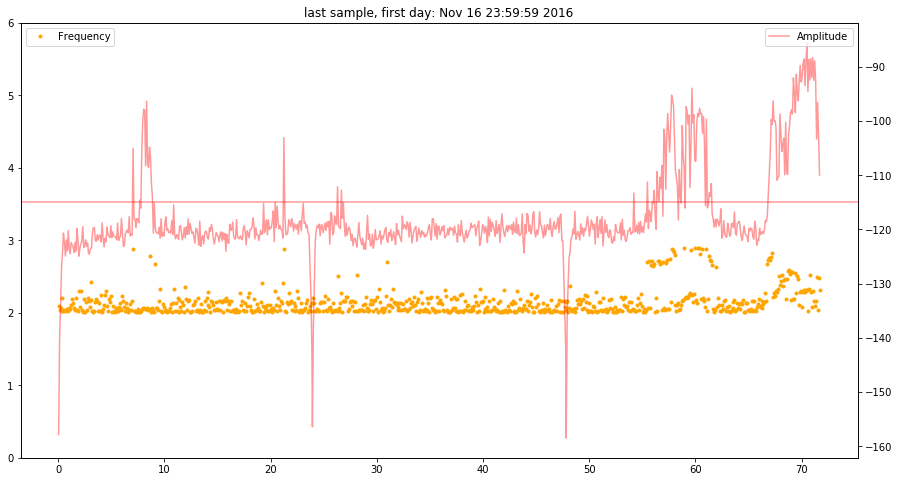

In [34]:
fig, ax1 = plt.subplots(figsize=(15,8))

ax1.plot(time_stack/3600, three_days_freq,'.', color='orange', label='Frequency')
ax1.legend(loc='upper left')
ax1.set_ylim((0,6))
ax2 = ax1.twinx()
ax2.plot(time_stack/3600,  10 * np.log10(three_days_amp), '-', color='red', alpha=.4, label='Amplitude')
ax2.axhline(-115, color='red', alpha=.4)
ax2.legend(loc='upper right')
plt.title('last sample, first day: ' + first_date)
plt.show()

In [114]:
print(first_date)

Nov 17 23:59:59 2016


## Short step into curve fitting

In [56]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline



In [57]:
def f(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

In [58]:
a, c = np.random.exponential(size=2)
b, d = np.random.randn(2)

In [59]:
n = 100
x = np.linspace(-10., 10., n)
y_model = f(x, a, b, c, d)
y = y_model + a * .2 * np.random.randn(n)

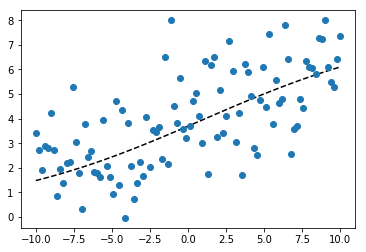

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, y_model, '--k')
ax.plot(x, y, 'o')

In [63]:
(a_, b_, c_, d_), _ = opt.curve_fit(f, x, y)

In [11]:
test = np.hstack((max_array_Z_masked, max_array_Z_masked1, max_array_Z_masked2))
time_stack = np.hstack((time, time[-1]+time, (time[-1]+time)[-1]+time))

In [12]:
#vmin_spec = 10 * np.log10(np.min(np.array([specgram_BHZ,specgram_BH1,specgram_BH2])))
#vmax_spec = 10 * np.log10(np.max(np.array([specgram_BHZ,specgram_BH1,specgram_BH2])))

/home/zmaw/u300967/.conda/envs/vgseis_2018/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/home/zmaw/u300967/.conda/envs/vgseis_2018/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/home/zmaw/u300967/.conda/envs/vgseis_2018/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/home/zmaw/u300967/.conda/envs/vgseis_2018/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


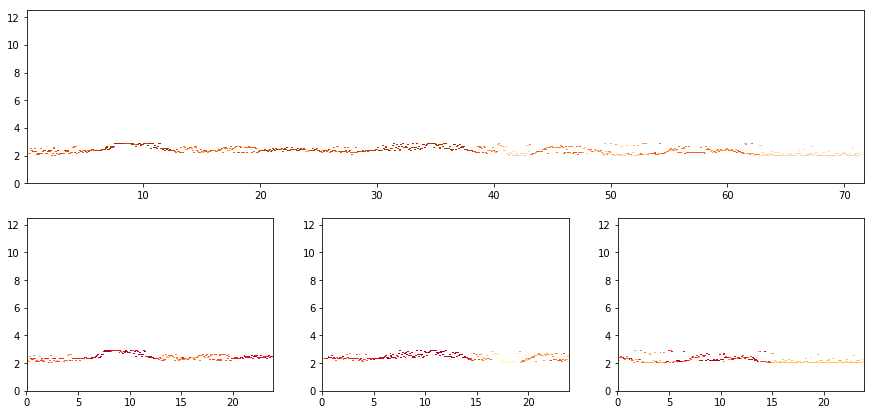

In [13]:
import matplotlib.gridspec as gridspec





fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7))
axs = axs.flatten()

gs = gridspec.GridSpec(2, 6)
gs.update(wspace=0.5)
axs[0] = plt.subplot(gs[0,:6])
axs[1] = plt.subplot(gs[1, :2])
axs[2] = plt.subplot(gs[1, 2:4])
axs[3] = plt.subplot(gs[1, 4:6])


axs[0].pcolormesh(time_stack/3600, freq, 10 * np.log10(test))
axs[1].pcolormesh(time/3600, freq,10 * np.log10(max_array_Z_masked), cmap='YlOrRd')
#axs[0].axhline(2, 0,86400, color='black')
#axs[1].pcolormesh(time, freq,10 * np.log10(specgram_BHZ), vmin=vmin_spec, vmax=vmax_spec, cmap='winter')
#axs[0].axhline(2, 0,86400, color='black')
#axs[0].pcolormesh(time, freq,10 * np.log10(specgram_BHZ_masekd1), vmin=vmin_spec, vmax=vmax_spec, cmap='winter')
#axs[0].pcolormesh(time, freq,10 * np.log10(max_array_Z), vmin=vmin_spec, vmax=vmax_spec, cmap='YlOrRd')

axs[2].pcolormesh(time/3600, freq,10 * np.log10(max_array_Z_masked1), cmap='YlOrRd')
axs[3].pcolormesh(time/3600, freq,10 * np.log10(max_array_Z_masked2), cmap='YlOrRd')

#axs[1].pcolormesh(time, freq,10 * np.log10(max_array_Z_masked1), vmin=vmin_spec, vmax=vmax_spec, cmap='YlOrRd')
#axs[1].pcolormesh(time, freq,10 * np.log10(max_array_Z_masked), vmin=vmin_spec, vmax=vmax_spec, cmap='YlOrRd')

axs[1].set
plt.show()

In [ ]:
print(np.any(test[:,42]))

In [ ]:
specgram_BHZ, freq, time = mlab.specgram(data_BHZ, Fs=fs, NFFT=nfft, noverlap=0)
specgram_BH1, freq, time = mlab.specgram(data_BH1, Fs=fs, NFFT=nfft, noverlap=0)
specgram_BH2, freq, time = mlab.specgram(data_BH2, Fs=fs, NFFT=nfft, noverlap=0)


#max_array_BHZ = np.zeros_like(specgram_BHZ)
#max_array_BH1 = np.zeros_like(specgram_BH1)
#max_array_BH2 = np.zeros_like(specgram_BH2)

threshold = np.amax(specgram_BHZ)*1e-25
freq_minimal_value = 3
distance = 120
maxima= 1
#all_win_average = np.mean(specgram.T)

max_array_Z = sorting_out_peacks(input_data=specgram_BHZ, freq_vec=freq, maxima=maxima, threshold = threshold, distance = distance, freq_minimal_value = freq_minimal_value)
max_array_1 = sorting_out_peacks(input_data=specgram_BH1, freq_vec=freq, maxima=maxima, threshold = threshold, distance = distance, freq_minimal_value = freq_minimal_value)
max_array_2 = sorting_out_peacks(input_data=specgram_BH2, freq_vec=freq, maxima=maxima, threshold = threshold, distance = distance, freq_minimal_value = freq_minimal_value)



vmin_amp =  10 * np.log10(np.min(np.hstack(([max_array_Z[max_array_Z != 0]], [max_array_1[max_array_1 != 0]],[max_array_2[max_array_2 != 0]]))))
vmax_amp =  10 * np.log10(np.max(np.array([max_array_Z,max_array_1,max_array_2])))
vmin_spec = 10 * np.log10(np.min(np.array([specgram_BHZ,specgram_BH1,specgram_BH2])))
vmax_spec = 10 * np.log10(np.max(np.array([specgram_BHZ,specgram_BH1,specgram_BH2])))

fig, ax = plt.subplots(figsize=(13,7))
specgramZ_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(specgram_BHZ[1:,:]), alpha=.99, cmap='winter', vmin=vmin_spec, vmax=vmax_spec)
amp_valZ_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(max_array_Z),cmap='YlOrRd', vmin=vmin_amp,vmax=vmax_amp)
#specgram_plot = ax.pcolormesh(10 * np.log10(specgram[1:,:]), alpha=1, cmap='winter')
#amp_val_plot = ax.pcolormesh(10 * np.log10(max_array), alpha=.5, cmap='YlOrRd')

plt.xticks(np.linspace(0,24,13))
plt.xlabel('Time [h]')
plt.ylabel('Frequency [Hz]')
plt.title(st_BHZ_simu_filt[0].stats.station + '_' + st_BHZ_simu_filt[0].stats.channel + '_' + date)

cbaxes = fig.add_axes([0, 0.1, 0.02, 0.8]) 
cb = plt.colorbar(specgramZ_plot, cax = cbaxes) 
cb.ax.set_ylabel('Amplitude [dB]')
cb.ax.get_yaxis().labelpad = -80
cbaxes = fig.add_axes([.95, 0.1, 0.02, 0.8]) 
cb = plt.colorbar(amp_valZ_plot, cax = cbaxes) 
cb.ax.set_ylabel('Amplitude [dB]', rotation=270)
cb.ax.get_yaxis().labelpad = 40



fig, ax = plt.subplots(figsize=(13,7))
specgram1_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(specgram_BH1[1:,:]), alpha=.99, cmap='winter',  vmin=vmin_spec, vmax=vmax_spec)
amp_val1_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(max_array_1),cmap='YlOrRd',vmin=vmin_amp,vmax=vmax_amp)
#specgram_plot = ax.pcolormesh(10 * np.log10(specgram[1:,:]), alpha=1, cmap='winter')
#amp_val_plot = ax.pcolormesh(10 * np.log10(max_array), alpha=.5, cmap='YlOrRd')

plt.xticks(np.linspace(0,24,13))
plt.xlabel('Time [h]')
plt.ylabel('Frequency [Hz]')
plt.title(st_BH1_simu_filt[0].stats.station + '_' + st_BH1_simu_filt[0].stats.channel + '_' + date)

cbaxes = fig.add_axes([0, 0.1, 0.02, 0.8]) 
cb = plt.colorbar(specgram1_plot, cax = cbaxes) 
cb.ax.set_ylabel('Amplitude [dB]')
cb.ax.get_yaxis().labelpad = -80
cbaxes = fig.add_axes([.95, 0.1, 0.02, 0.8]) 
cb = plt.colorbar(amp_val1_plot, cax = cbaxes) 
cb.ax.set_ylabel('Amplitude [dB]', rotation=270)
cb.ax.get_yaxis().labelpad = 40


fig, ax = plt.subplots(figsize=(13,7))
specgram2_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(specgram_BH2[1:,:]), alpha=.99, cmap='winter',  vmin=vmin_spec, vmax=vmax_spec)
amp_val2_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(max_array_2),cmap='YlOrRd', vmin=vmin_amp,vmax=vmax_amp)
#specgram_plot = ax.pcolormesh(10 * np.log10(specgram[1:,:]), alpha=1, cmap='winter')
#amp_val_plot = ax.pcolormesh(10 * np.log10(max_array), alpha=.5, cmap='YlOrRd')

plt.xticks(np.linspace(0,24,13))
plt.xlabel('Time [h]')
plt.ylabel('Frequency [Hz]')
plt.title(st_BH2_simu_filt[0].stats.station + '_' + st_BH2_simu_filt[0].stats.channel + '_' + date)

cbaxes = fig.add_axes([0, 0.1, 0.02, 0.8]) 
cb = plt.colorbar(specgram2_plot, cax = cbaxes) 
cb.ax.set_ylabel('Amplitude [dB]')
cb.ax.get_yaxis().labelpad = -80
cbaxes = fig.add_axes([.95, 0.1, 0.02, 0.8]) 
cb = plt.colorbar(amp_val2_plot, cax = cbaxes) 
cb.ax.set_ylabel('Amplitude [dB]', rotation=270)
cb.ax.get_yaxis().labelpad = 40


#plt.xlim(2,6)
#plt.ylim(0,4)
#plt.grid(alpha=.1)


plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(13,7))
specgram_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(specgram[1:,:]), alpha=.6, cmap='winter')
amp_val_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(max_array),cmap='YlOrRd')
#specgram_plot = ax.pcolormesh(10 * np.log10(specgram[1:,:]), alpha=1, cmap='winter')
#amp_val_plot = ax.pcolormesh(10 * np.log10(max_array), alpha=.5, cmap='YlOrRd')
cbar = plt.colorbar(amp_val_plot)
cbar.set_clim(-160,-80)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('dB-scale', rotation=270)

plt.xticks(np.linspace(0,24,13))
#plt.xlim(2,6)
#plt.ylim(0,4)
#plt.grid(alpha=.1)

plt.xlabel('Time [h]')
plt.ylabel('Frequency [Hz]')
plt.show()

In [ ]:



fig, ax = plt.subplots(figsize=(13,7))
specgramZ_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(specgram_BHZ[1:,:]), alpha=.8, cmap='winter', vmin=vmin_spec, vmax=vmax_spec)
amp_valZ_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(max_array_Z),cmap='YlOrRd', vmin=vmin_amp,vmax=vmax_amp)
plt.xlabel('Time [h]')
plt.ylabel('Frequency [Hz]')
plt.title(st_BHZ_simu_filt[0].stats.station + '_' + st_BHZ_simu_filt[0].stats.channel + '_' + date)
#specgram_plot = ax.pcolormesh(10 * np.log10(specgram[1:,:]), alpha=1, cmap='winter')
#amp_val_plot = ax.pcolormesh(10 * np.log10(max_array), alpha=.5, cmap='YlOrRd')
cbaxes = fig.add_axes([0, 0.1, 0.02, 0.8]) 
cb = plt.colorbar(specgramZ_plot, cax = cbaxes) 
cb.ax.set_ylabel('dB-scale')
cb.ax.get_yaxis().labelpad = -80
cbaxes = fig.add_axes([.95, 0.1, 0.02, 0.8]) 
cb = plt.colorbar(amp_valZ_plot, cax = cbaxes) 
cb.ax.set_ylabel('dB-scale', rotation=270)
cb.ax.get_yaxis().labelpad = 40
#

#cbar.set_clim(vmin,vmax)
#cbar.ax.get_yaxis().labelpad = 15
#cbar.ax.set_ylabel('dB-scale', rotation=270)

plt.xticks(np.linspace(0,24,13))
#plt.xlim(2,6)
#plt.ylim(0,4)
#plt.grid(alpha=.1)
plt.show()